<img style="max-width:20em; height:auto;" src="../graphics/A-Little-Book-on-Adversarial-AI-Cover.png"/>

Author: Nik Alleyne   
Author Blog: https://www.securitynik.com   
Author GitHub: github.com/securitynik   

Author Other Books: [   

            "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",   
            
            "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/"   
        ]   


This notebook ***(dc_gan_mnist.ipynb)*** is part of the series of notebooks From ***A Little Book on Adversarial AI***  A free ebook released by Nik Alleyne

**Building a better Generative Adversarial Network (GAN) for MNIST images**   
### Deep Convolutional Generative Adversarial Networks (DCGAN)   

https://debuggercafe.com/dcgan-pytorch/  

This architecture is fully convolutional. There are no fully connected or max pool layers, as is seen in traditional convolutional networks. 

Batch normalization is used to normalize the input each convolution layer. It also helps to address the gradient flow in networks that may be poortly initialized. 

Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks
https://arxiv.org/abs/1511.06434   

How to Train a GAN? Tips and tricks to make GANs work   
https://github.com/soumith/ganhacks   


Generating GAN images by training on the MNIST dataset   
https://medium.com/aimonks/generating-gan-images-from-training-on-mnist-dataset-2e2ec53dfe96   
https://ai.plainenglish.io/introduction-to-generative-adversarial-networks-gans-67c43db09aea   

### Lab Objectives:   
- Build a better GAN using Convolution and Conv Transposed layers  
- Understand how to use Convolution layers       
- Understand how to use Convolution Transposed layers  
- See how a DCGAN generates better quality images   

### Step 1:  

In [1]:
# Let's start by importing our libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchinfo
from torchvision.transforms import v2
from torchvision.datasets import MNIST
import netron
import IPython
from tqdm import tqdm

from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
### Version of key libraries used  
print(f'Torch version used:  {torch.__version__}')
print(f'Torchinfo version used:  {torchinfo.__version__}')
print(f'Netron version used:  {netron.__version__}')

Torch version used:  2.7.1+cu128
Torchinfo version used:  1.8.0
Netron version used:  8.4.4


In [3]:
# GANs can be very computational expensive to train, hence, let's make the code device agnostic

# Setup the device to work with
# This should ensure if there are accelerators in place, such as Apple backend or CUDA, 
# we should be able to take advantage of it.

if torch.cuda.is_available():
    print('Setting the device to cuda')
    device = 'cuda'
elif torch.backends.mps.is_available():
    print('Setting the device to Apple mps')
    device = 'mps'
else:
    print('Setting the device to CPU')
    device = torch.device('cpu')

Setting the device to cuda


When working with neural networks. We have a number of hyperparameters to define, based on the type of architecture we will be using. For us, we will be using Linear Layers.  

- The input dimension for our generator will be 100. 
- To keep things simple as always, we use grayscale image. This means rather than RGB with 3 channels, we instead have 1.  
- Our image size will be 28x28
- We define our batch size as 128. This is the amount of samples we will process in one go. Earlier we learned about datasets and dataloaders in the **dataset_dataloader.ipynb** notebook. As a result, the expectation is you have a solid understanding of what is being done here.  
- Just for simplicity, we will train for 25 epochs 
- We will set our learning rate to 0.0002. This is an important hyperparameter and can make or break your GAN.  
- We set the adam_beta1 to 0.5 
- We specify our hidden layers as 256. We can expand and or reduce on this as we go forward.   

In [4]:
# Define the hyperparameters for the discriminator and generator
z_dim = 100
img_chnl = 1
img_sz = 28
batch_sz = 128
n_epochs = 10   # In the previous lab this was 25. 
lr = 0.0002         # Try setting this to 0.1 and see what happens ;-) 
adam_beta1 = 0.5
hidden_layers = 256

# Image directory
img_dir = r'/tmp/mnist_data/'

# Hyperparameters specifically for the  Convolution layers
img_chnl = 1                                  # Number of channels in the input image
n_filters = 256                                 # Filter number of filters in the generator 
stride = 2                                      # Stride for the 2nd to last layers
kernel_size = 4                                 # Size of the convolution kernel


In [5]:
# Setup the transform for the image
# Not really needed for this problem.
# However, in practice you should use this to ensure consistency across your inputs
transform = v2.Compose(transforms=[
    #v2.Resize(size=img_sz),
    v2.ToImage(),
    v2.ToDtype(dtype=torch.float32, scale=True),
    v2.Normalize(mean=[.5], std=[.5])
])

The MNIST dataset is being used, so that we have something we can work though. This concept however applies to any dataset. 

### Step 2:  

In [6]:
# Get the training data
X_real_train_images = MNIST(root=img_dir, train=True, download=True, transform=transform)
X_real_train_images

Dataset MNIST
    Number of datapoints: 60000
    Root location: /tmp/mnist_data/
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
                 Normalize(mean=[0.5], std=[0.5], inplace=False)
           )

In [7]:
# Get the length of the dataset
print(f'Length of the datast: {len(X_real_train_images)}')

Length of the datast: 60000


In [8]:
# Setup the dataloader
X_train_loader = DataLoader(dataset=X_real_train_images, batch_size=batch_sz, shuffle=True)
X_train_loader

In [9]:
# Get a sample batch:
# Notice images are now values between -1 and 1
# Also there are labels. We don't need these labels as this is an unsupervised learning problem. 
sample_batch = next(iter(X_train_loader))
sample_batch[0][:5], sample_batch[1][:5]

(tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           ...,
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.],
           [-1., -1., -1.,  ..., -1., -1., -1.]]],
 
 
         [[[-1., -1., -1.,  ..., -1., -1., -1.],
   

In [10]:
# Get the shape of the first bach.
# No surprises here, we have 128 items with 1 channel and 28 pixels high and 28 pixels wide. 
sample_batch[0].shape

torch.Size([128, 1, 28, 28])

In [11]:
# Looking at the labels
# No surprises here, we have 128 labels
sample_batch[1].size()

torch.Size([128])

In [12]:
# Get a better view into one sample
# Get the fatures and the label of the first item in the bach
sample_batch[0][0], sample_batch[1][0]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

As always, we visualize the data before attempting to build any models. 

### Step 3:   

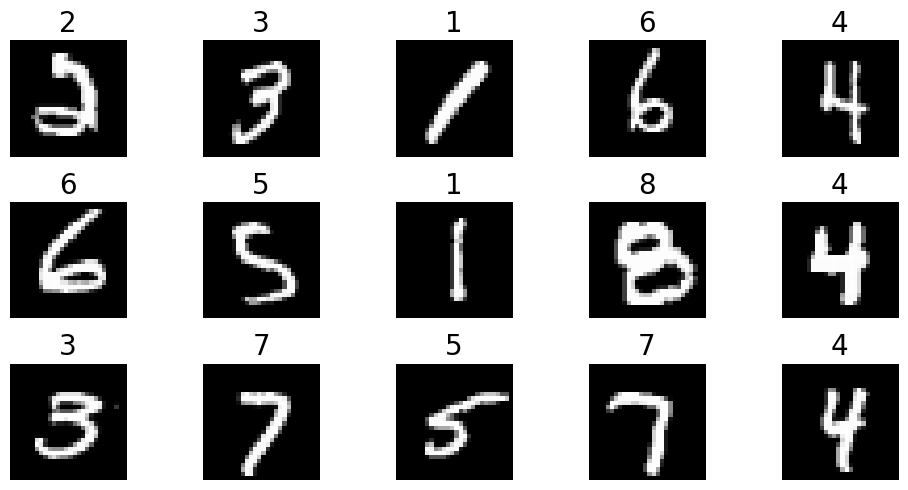

In [13]:
# Plot a few of the images
# While those images can be viewed in colour, we have to remember our img_chnls variable above is assigned 1 (img_chnls = 1), hence this is a grayscale image
# We did this in the previous lab. 
# Just keeping it here if you wish to use it.
# Just uncomment the lines if needed
# Then again, each of these notebooks should be able to work on its own :-D 

fig = plt.figure(figsize=(10,5))
for i in range(15):
    ax = fig.add_subplot(3,5,i+1)
    ax.set_title(label=f'{sample_batch[1][i]}', fontdict={'size' : 20})
    ax.imshow(sample_batch[0][i].view(img_sz,img_sz), cmap='gray')
    ax.set_axis_off()

plt.tight_layout()

In [14]:
# Let's put above in a function we can call later
# Same here
# We did this in the previous lab. 
# Just keeping it here if you wish to use it.
# Then again, each of these notebooks should be able to work on its own :-D

def plot_images(image_src=None, label=None):
    fig = plt.figure(figsize=(10,5))
    for i in range(15):
        ax = fig.add_subplot(3,5,i+1)
        ax.set_title(label=f'{label[i]}' if label != None else ' ', fontdict={'size' : 20})
        ax.imshow(image_src[i].view(img_sz,img_sz), cmap='gray')
        ax.set_axis_off()

    plt.tight_layout()

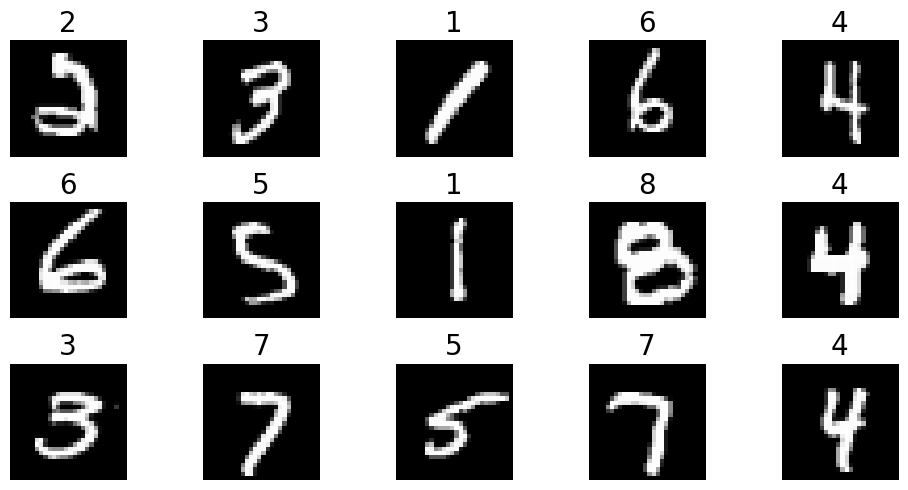

In [15]:
# Call the function to verify it works
plot_images(image_src=sample_batch[0], label=sample_batch[1])

If we wanted we could also look at this from a grid perspective. This is what we will use ultimately. Just learning different tricks as we go along.   

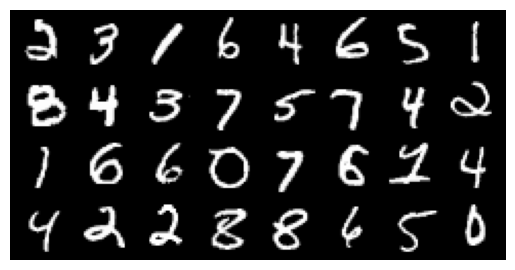

In [16]:
# Taking a batch of 32 items
# Note permute here shifts the dimensions around.
# These images are shaped colour channel, height, width.
# For Matplotlib, we will move the colour channel to the end. Hence our shape will be height, width, colour channel

plt.imshow(make_grid(sample_batch[0][:32], normalize=True).permute(dims=[1, 2, 0]))
plt.axis('off');

In [17]:
# As always, put the above in a function that we can call anytime on either the real or fake image
# In this case, we call it on the rela image.
def plot_images_grid(image_src=None, n_images=0):
    image_grid = make_grid(tensor=image_src[:n_images], normalize=True)

    # These images are shaped colour channel, height, width.
    # For Matplotlib, we will move the colour channel to the end. Hence our shape will be height, width, colour channel
    # This is why we use permute
    image_grid = image_grid.permute(dims=[1,2,0])

    # plot the grid
    plt.imshow(X=image_grid)
    plt.axis('off')
    plt.show()

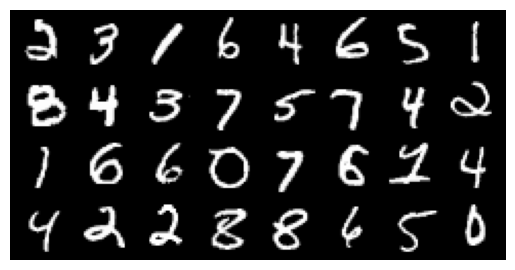

In [18]:
# Test the function
plot_images_grid(image_src=sample_batch[0], n_images=32)

What makes GANs interesting, is their ability to generate real looking images, that are similar to the distribution they were trained on.  
The generator is responsible for generating these fake images that looks like real images, thus having the discriminator classify them as real images. 
In GANs, both the generaztor and discriminator are trained together from scratch, providing feedback to each other, allowing each other to get better as the training progresses.

<img style="max-width:200em; height:auto;"  src="../graphics/dcgan.png"/><br>
source: https://user-images.githubusercontent.com/26786663/27525317-b3026976-5a77-11e7-8767-8f4a06e5b696.jpg 

Above shows that the GAN consists of both an encoder and a decoder. The encoder leverages the convolutional layers while the decoder leverages the deconvolution also called Transposed Convolutional layers.   


## Step 4:  

In [19]:
# Freeze the random number generator for reproducibility 
torch.manual_seed(10)

# Setup a random batch of 128 images similar to the true images
# This is random noise at this point
sample_noise = torch.randn(size=(batch_sz, z_dim, 1, 1))
sample_noise.size()

# Comment out the line below if you wish to see what the output looks like
#sample_noise[:, 0, :, :], 

torch.Size([128, 100, 1, 1])

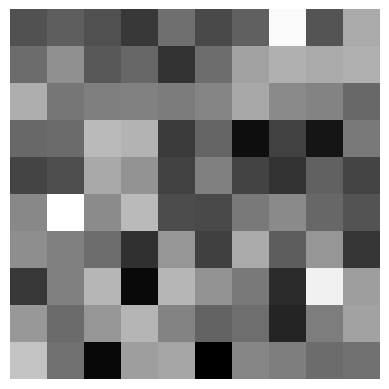

In [20]:
# Visualize the noise, using 1 sample
# Reshaping it as a 10x10 input for easy visualization
plt.imshow(sample_noise[0].view(10,10), cmap='gray')
plt.axis('off');

The generator starts from the above noise and must be able to produce images as seen earlier above of the numbers.  The objective is to learn via the training process, to move from this noise a valid number. Or in other cases a valid face, or whatever else the threat actor would like to generate.  

Building the generator portion of the our simple GAN <br>
<img style="max-width:200em; height:auto;"  src='../graphics/dcgan_generator.png'><br>
Source: https://arxiv.org/pdf/1511.06434     

Rather than moving z from 100 channels to 1024 as is in the image above, for simplicity and to speed up the process, we set **n_filters=256** earlier.   

This means rather than moving from 1024 -> 512 -> 256 -> 128, which show the number is being halved every time, we instead move from 256 -> 128.   

Additionally, while the final layer has 3 channels, because it is a full colour (RGB) image, we are using **imc_chnl=1** because this is a black and white/gray scale image.  

This also means we are using three convolutional layers overall in this generator   

### Step 5:  


In [21]:
# Building the generator
# This is what needs to take the fake images to get them to real looking images
class Generator(nn.Module):
    def __init__(self, z_dim=z_dim):
        super(Generator, self).__init__()
        
        self.gen_layers = nn.Sequential(
            # The key for this generator is the ConvTranspose2d layer
            # Because we are using BatchNorm after the ConvTranspose2d layer, we set the bias to False in the ConvTransposed2d Layer
            nn.ConvTranspose2d(in_channels=z_dim, out_channels=n_filters, kernel_size=kernel_size + 3, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(num_features=n_filters),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=n_filters, out_channels=n_filters // 2, kernel_size=kernel_size, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(num_features=n_filters // 2),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(in_channels=n_filters // 2, out_channels=img_chnl, kernel_size=kernel_size, stride=stride, padding=1, bias=True),

            # Here we are using Tanh as the activation function
            # It forces the output to be between -1 and +1
            # If you remember, at the top our output from *sample_batch* has values such as -1, +1 and values inbetween
            nn.Tanh(),

        )

        # This is to ensure our Convolutional layer weights have a mean of 0 and a truncated standar deviation of .02
        # It also ensures our batch norm layer has a mean of 1 and a standard deviation of .02
        # Finally the bias is set to 0 in the batch norm layer
        # If you are wondering how I came up with these parameters, I did not. 
        # These are values researches have found to work best. 
        # I am building on their work
        self.apply(self._initialize_weights)
     
    def forward(self, z):
        return self.gen_layers(z)
    
    # The notes above is above for this function
    def _initialize_weights(self, m):
        for child in self.children():
            for m in child.modules():
                if isinstance(m, nn.ConvTranspose2d):
                    nn.init.normal_(tensor=m.weight.data, mean=0., std=.02)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.normal_(tensor=m.weight.data, mean=1., std=0.02)
                    nn.init.constant_(tensor=m.bias.data, val=0.)


In [22]:
# Instantiate the Generator class
# The seed is set so that the weights you and I see are the same.
torch.manual_seed(seed=20)
g_model = Generator()

# See the model's parameters
g_model.state_dict()

# Get a look at the parameters count
torchinfo.summary(model=g_model)

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─ConvTranspose2d: 2-1              1,254,400
│    └─BatchNorm2d: 2-2                  512
│    └─ReLU: 2-3                         --
│    └─ConvTranspose2d: 2-4              524,288
│    └─BatchNorm2d: 2-5                  256
│    └─ReLU: 2-6                         --
│    └─ConvTranspose2d: 2-7              2,049
│    └─Tanh: 2-8                         --
Total params: 1,781,505
Trainable params: 1,781,505
Non-trainable params: 0

In [23]:
# Pass the sample noise created above to the generator
# This is just to ensure that we can pass our random noise in. 
# This is on an untrained generator
g_model(sample_noise).size()

torch.Size([128, 1, 28, 28])

Visualize the results from the untrained model   

### Step 6:   

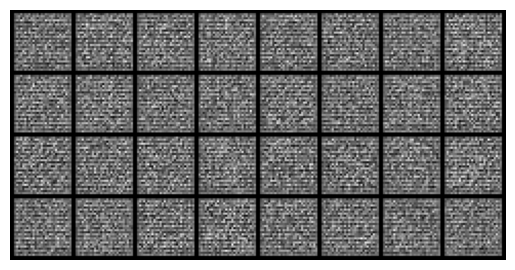

In [24]:
# Visualize a batch of 32 samples from the noised passed through to the untrained generator
z_tmp = torch.randn(size=(32, z_dim, 1, 1))
fake_img_tmp = g_model(z_tmp)#.view(-1, 1, 28, 28)
fake_img_grid = make_grid(tensor=fake_img_tmp, normalize=True).permute(dims=(1,2,0))
plt.imshow(X=fake_img_grid)     
plt.axis('off')       
plt.show()

Nothing meaningful above. This is expected. 

Above suggests our generator is working. It has not been trained as yet, but we are still able to pass our noise to it without any errors being returned. Let us look at the computation graph with *netron*.

### Step 7:  

In [25]:
# Visualize the generator model
torch.onnx.export(model=g_model, args=sample_noise, f=r'/tmp/dc_gan_g_model.onnx.pth', dynamo=True, input_names=['z_random_noise'], output_names=['generated_image'])

# Load up the model via netron
netron.start(file=r'/tmp/dc_gan_g_model.onnx.pth', browse=False, address=('127.0.0.1', 8888))

# Visualize the model's computation graph inline of the notebook
IPython.display.IFrame('http://localhost:8888', width=700, height=700)

[torch.onnx] Obtain model graph for `Generator([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Generator([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Serving '/tmp/dc_gan_g_model.onnx.pth' at http://127.0.0.1:8888


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


With the model built and the architecture visualized, let us see how the untrained generator model does on our random noise. There should be no expectation of seeing anything meaningful such as a number. This is because the model has not learnt anything as yet.

### Step 8:  

In [26]:
# Build the Discriminator 
# This is responsible for determining if an input is fake or real
class Discriminator(nn.Module):
    def __init__(self, ):
        super(Discriminator, self).__init__()

        self.des_layers = nn.Sequential(
            # Key here is the convolutional layers
            # Notice that with the Generator, we started off at 100 -> 256 -> 128 -> 1
            # Now we are at 1 -> 128 -> 256 -> 1
            nn.Conv2d(in_channels=img_chnl, out_channels=n_filters // 2, kernel_size=kernel_size, stride=stride, padding=1, bias=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(in_channels=n_filters // 2, out_channels=n_filters, kernel_size=kernel_size, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(num_features=n_filters),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(in_channels=n_filters, out_channels=img_chnl, kernel_size=kernel_size + 3, stride=stride-1, padding=0, bias=True),

            # The output from the previous layer is squashed to values between 0 and 1
            # These values can be interpreted as probabilities
            # Hence we are getting the probability of the sample being real (1) or fake (0)
            nn.Sigmoid(),

        )

        self.apply(fn= self._initialize_weights)

    # Initialize the weights with a mean of and a truncated standard deviation of .02
    # Set the bias as 0 for the BatchNorm
    # These are the same for what was done above with the Generator
    def _initialize_weights(self, m):
        for child in self.children():
            for m in child.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.normal_(tensor=m.weight.data, mean=0., std=.02)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.normal_(tensor=m.weight.data, mean=1., std=0.02)
                    nn.init.constant_(tensor=m.bias.data, val=0.)

    def forward(self, x):
        x = self.des_layers(x)
        return x.view(-1, 1)
    

In [27]:
# Setup the seed for reproducibility
torch.manual_seed(seed=20)

# Instantiate the Discriminator
d_model = Discriminator()
d_model.state_dict()

# Get the parameters again
torchinfo.summary(model=d_model)

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       2,176
│    └─LeakyReLU: 2-2                    --
│    └─Conv2d: 2-3                       524,288
│    └─BatchNorm2d: 2-4                  512
│    └─LeakyReLU: 2-5                    --
│    └─Conv2d: 2-6                       12,545
│    └─Sigmoid: 2-7                      --
Total params: 539,521
Trainable params: 539,521
Non-trainable params: 0

In [28]:
print(f'Currently the sample data has shape: {sample_batch[0].size()}')

# pass it to the untrained model
d_model(sample_batch[0])[:5]

Currently the sample data has shape: torch.Size([128, 1, 28, 28])


tensor([[0.9854],
        [0.9935],
        [0.8540],
        [0.9702],
        [0.9320]], grad_fn=<SliceBackward0>)

With both the Generator (generate samples) and the discriminator designed, it is time to train the GAN. Before we do, let us once again, visualize our computation graph. This time for the Discriminator. 


### Step 10:  


In [29]:
# Visualize the network
# Visualize the generator model
torch.onnx.export(model=d_model, args=sample_batch[0], f=r'/tmp/dcgan_d_model.onnx.pth', dynamo=True, input_names=['real_and_fake_images'], output_names=['probability_of_real'])
netron.start(file=r'/tmp/dcgan_d_model.onnx.pth', browse=False, address=('127.0.0.1', 8888))
IPython.display.IFrame('http://localhost:8888', width=500, height=500)


[torch.onnx] Obtain model graph for `Discriminator([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Discriminator([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Removed 15 unused nodes
No unused functions to remove
Removed 6 unused nodes
No unused functions to remove
No unused functions to remove
PassManager: No more graph changes detected after step 1
Stopping http://127.0.0.1:8888
Serving '/tmp/dcgan_d_model.onnx.pth' at http://127.0.0.1:8888


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅


Ok, now we can get to training the network. We have to define a loss function as well as an optimizer. We will use one loss function for both the generator and discriminator. However for the optimizer, we define one for the generator and the other for the discriminator


### Step 11:


In [30]:
# Move both bodels to the device
d_model = d_model.to(device=device)
g_model = g_model.to(device=device)


# Setup the Binary Crossentropy loss. This will be used by both the Generator and Discriminator
adversarial_loss = nn.BCELoss()

# However, we need two different optimizers, one for the Discriminator and the other for the Generator
d_optimizer = torch.optim.Adam(params=d_model.parameters(), lr=lr, betas=(adam_beta1, 0.999))

# Define the optimizer for the generator
g_optimizer = torch.optim.Adam(params=g_model.parameters(), lr=lr, betas=(adam_beta1, 0.999))

In [31]:
# Before training, let's optimize this training process
# https://pytorch.org/tutorials/recipes/recipes/tuning_guide.html
# We are working on CPUs in most cases and would like to make the most out of it
# These are mostly used for debugging

torch.autograd.set_detect_anomaly(mode=False)
torch.autograd.profiler.profile(enabled=False)
torch.autograd.profiler.emit_nvtx(enabled=False)


epoch: 5/10: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s] 


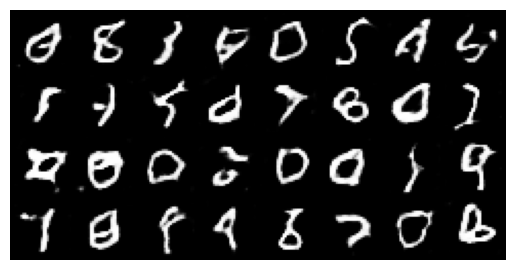

Generator loss: 1.0714 	 Discriminator loss: 0.3426


epoch: 10/10: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s] 


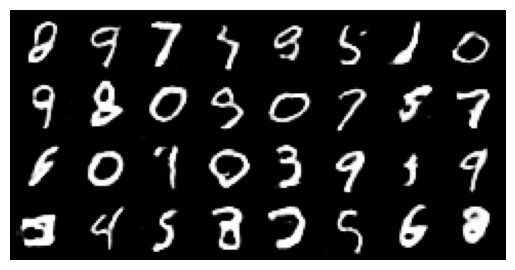

Generator loss: 3.4738 	 Discriminator loss: 0.4411


In [32]:
# Start a training loop
for epoch in range(n_epochs):

    # Cycle through the data in batches of batch_sz -> defaults to 128
    for real_X, _ in tqdm(X_train_loader, desc=f'epoch: {epoch + 1}/{n_epochs}'):

        # Move the real_X to device
        real_X = real_X.to(device=device)

        # Get the batch size of the images, by looking at the first dimension
        b = real_X.size(dim=0)

        # Reshape the real_X from -1, 1, 28, 28 -> (batch_size, channels, height, width) to -1, 784 -> (batch_sz, features)
        #real_X = real_X.view(b, -1)
        
        # Create The real and fake labels for each batch
        real_y = torch.ones(size=(b, 1), device=device)
        fake_y = torch.zeros(size=(b, 1), device=device)

        # Create z (noise) for the generator
        z = torch.randn(size=(b, z_dim, 1, 1), device=device)
        
        # ----- Start off by using the generator -----
        g_optimizer.zero_grad(set_to_none=True)
        fake_img = g_model(z)
        d_model_out = d_model(fake_img)
        gen_loss = adversarial_loss(d_model_out, real_y)
        gen_loss.backward()
        g_optimizer.step()

        # ----- Generator End -----


        # ----- Discriminator starts here -----
        d_optimizer.zero_grad(set_to_none=True)
        
        d_real_out = d_model(real_X)
        d_real_loss = adversarial_loss(input=d_real_out, target=real_y)

        d_fake_out = d_model(fake_img.detach())
        d_fake_loss = adversarial_loss(input=d_fake_out, target=fake_y)

        # get the losses
        d_final_loss = (d_real_loss + d_fake_loss) / 2
        d_final_loss.backward()
        d_optimizer.step()

        # ----- Discriminator ends here -----
        
        #break
    
    # At every 5 epochs, print the loss information as well generate a grid of the images so far.
    # This allows us to visualize the learning process
    if (epoch + 1) % 5 == 0:
        with torch.inference_mode():
            # Generate a batch of 32 samples
            z_tmp = torch.randn(size=(32, z_dim, 1, 1), device=device)
            fake_img_tmp = g_model(z_tmp)#.view(-1, 1, 28, 28)

            # permute here is used to move the dimensions around so we could visualize the images
            fake_img_grid = make_grid(tensor=fake_img_tmp.cpu(), normalize=True).permute(dims=(1,2,0))
            plt.imshow(X=fake_img_grid)     
            plt.axis('off')       
            plt.show()

        print(f'Generator loss: {gen_loss:.4f} \t Discriminator loss: {d_final_loss:.4f}')
        make_grid
    #break

It is common to see the losses in the GANs fluctuating, which might suggest the model is not learning. However, don't be fooled. One reason for this is what is called the state of equilibrium. That is when the generator is generating data that is realistic enough to fool the discriminator but not realistic enough that the discriminator is easily able to distinguish real from fake. While the loss may not seem to improve, the generated data can still be of high quality.  This is why what matters most to monitor the generated data visually than the loss. 

As can be seen above, we were able to generate new images from random noise, using a more sophisticated GAN. Think about this from the perspective to generate new faces to bypass biometric solutions. Generating fingerprints data to bypass biometric solutions, etc.

At this point, one can *discard* the discriminator and only save the generator. The generator is what is needed for generating future fake data.

Notice also, we have higher quality images in a fewer epochs. This is because we used a more sophisticated architecture used in computer vision, that is the convolutional network. Obviously it took longer to train, but we now have higher quality images.

### Step 12: 


In [33]:
# Save the model
torch.jit.script(g_model).save(f=r'/tmp/dcgan_generator.pt')

# Verify the file has been saved
!ls /tmp/generator.pth

/tmp/generator.pth


With the model saved, we can just share it with our applications teams and load in our desired application.  

### Step 13:  

In [34]:
# Load the model
loaded_generator = torch.jit.load(f=r'/tmp/dcgan_generator.pt', map_location=device)

# Put the generator in eval model
# This step is not as important for us 
# it is however good practice
# Dropout operates differently during training and inferences
# We are making inference
loaded_generator.eval()

RecursiveScriptModule(
  original_name=Generator
  (gen_layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=ConvTranspose2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
    (3): RecursiveScriptModule(original_name=ConvTranspose2d)
    (4): RecursiveScriptModule(original_name=BatchNorm2d)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=ConvTranspose2d)
    (7): RecursiveScriptModule(original_name=Tanh)
  )
)

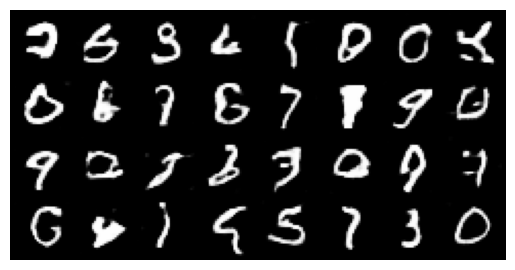

In [35]:
# Generate some new images and visualize them, using the loaded model
with torch.inference_mode():
    new_z = torch.randn(size=(32, z_dim, 1, 1), device=device)
    new_fake_img = loaded_generator(new_z) #.view(-1, 1, 28, 28)
    fake_img_grid = make_grid(tensor=new_fake_img, normalize=True).permute(dims=(1,2,0))
    plt.imshow(X=fake_img_grid.cpu())     
    plt.axis('off')       
    plt.show()

In [36]:
# With the training finish clear the GPU cache
# Setup the device to work with
if torch.cuda.is_available():
    # For CUDA GPU
    print(f'Cleaning {device} cache')
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    # For Apple devices
    print(f'Cleaning {device} cache')
    torch.mps.empty_cache()
else:
    # Default to cpu
    pass

Cleaning cuda cache


### That's it for our Deep Convolutional Generative Adversarial Network (DCGAN) GAN! 

### Lab Takeaways   
- We were able to build a Deep Convolutional Generative Adversarial Network (DCGAN)   
- We built our GAN using a combination of Convolutional layers and ConvTransposed layers 
- We learnt that a DCGAN consists of two components, a generator and a discriminator      
- We learnt that a the generator, is responsibile for creating the fake input/images/videos, etc.    
- We learnt that the discriminator is responsible for detecting those fake input/images/videos, etc.    
- We saw that DCGAN works better than a vanilla GAN.